In [1]:
# Scientific computing
import numpy as np
np.random.seed(2020)
import scipy.stats as ss
from multiprocessing import Pool
from scipy import random, linalg
from sklearn.datasets import make_spd_matrix
from scipy.linalg import fractional_matrix_power

# General utilities
import os
from tqdm import tqdm
import time

# Plotting functionality
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm

# Make display wider
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def himmelblau_loss(W):
    """
    Himmelblau loss function: f(x,y) = (x^2+y-11)^2 + (x+y^2-7)^2
    """
    x, y = W
    return (x**2+y-11)**2 + (x+y**2-7)**2

    

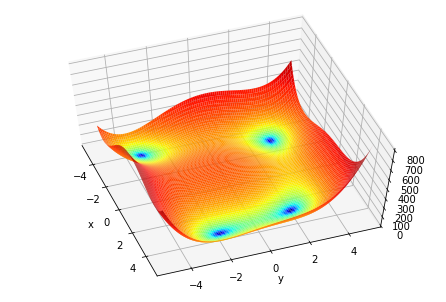

In [3]:
# Surface plot 
fig = plt.figure()
ax = Axes3D(fig, azim = -29, elev = 49)
X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = himmelblau_loss([X,Y])
ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1, norm = LogNorm(), cmap = cm.jet)
ax.view_init(60, -20)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [4]:
def contour_plot_trajectory(X, Y, Z, path):
    """
    To do: confirm that this funcion will not be useful at some point
    """
    fig, ax = plt.subplots(figsize=(8,6))
    ax.contour(X, Y, Z,levels=np.logspace(0, 3.4, 35), norm = LogNorm(), cmap = cm.jet)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title('Himmelblau loss function trajectory')
    
    # Plot trajectory
    color = 'black'
    ax.quiver(path[:-1,0], path[:-1,1], path[1:,0]-path[:-1,0], path[1:,1]-path[:-1,1],
              scale_units='xy', angles='xy', scale=1,color=color)
    ax.scatter(path[:,0],path[:,1], color=color, marker='o', s=35)
    
def contour_plot_iteration(X, Y, Z, population, elite, mu, iteration, reward, ax = None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))
    ax.contour(X, Y, Z,levels=np.logspace(0, 3.4, 35), norm = LogNorm(), cmap = cm.jet)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f'Iteration {iteration}. Loss: {round(reward,2)}')
    
    
    # Plot trajectory
    ax.scatter(population[:,0], population[:,1], color='black', marker='o', s=20,zorder=3)
    ax.scatter(mu[0], mu[1], zorder=3,marker='x',s=100, color='purple',label='mean')
    ax.scatter(elite[:,0], elite[:,1], zorder=3,marker='o',s=25, color='red',label='elite')

    
def plot_reward(n_iter,reward, lower_is_better=True):
    plt.figure(figsize=(12,6))
    plt.title('Fitness over time')
    plt.plot(np.arange(n_iter), reward[:,0], label='Population mean')
    if lower_is_better:
        plt.plot(np.arange(n_iter), np.min(reward,axis=1), label='Best performer in population')
        #plt.plot(np.arange(n_iter), np.max(reward,axis=1), label='Worst performer in population')
    else:
        plt.plot(np.arange(n_iter), np.max(reward,axis=1), label='Best performer in population')
        #plt.plot(np.arange(n_iter), np.min(reward,axis=1), label='Worst performer in population')
    plt.xlabel('generation')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

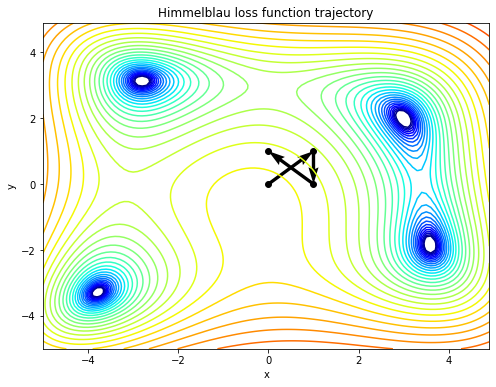

TypeError: contour_plot_iteration() missing 2 required positional arguments: 'mu' and 'iteration'

In [5]:
# Plot trajectory
test_path = np.array([[0,0],[1,1],[1,0], [0,1]])
contour_plot_trajectory(X, Y, Z, test_path)
plt.show()

# Plot iteration
contour_plot_iteration(X, Y, Z, test_path, 1, reward=himmelblau_loss([0.5,0.5]))
plt.show()

In [ ]:
class classic_ES():
    
    def __init__(self, Λ, λ, w_dim):
        """
        Gaussian Evolution Strategy algorithm (without covariances)
        :param Λ         (float) population size
        :param λ         (float) elite group size 
        :param Σ_0       (array) initial covariance matrix
        :param w_dim     (int) shape of weights to be optimized
        """
        self.λ = λ
        self.Λ = Λ
        self.w_dim = w_dim
        self.weights = np.random.normal(0,1,w_dim)
        self.σ = 1 
        
    def train(self, n_iter, loss_func):
        """
        :param n_iter    (int) number of iterations
        :param loss_func (function) loss function to be optimized 

        :return θ        (matrix) parameter values for each iteration, 
        :return fitness  (matrix) fitness score for each member for each iteration
        """
        Λ, λ   = self.Λ, self.λ
        w, σ   = self.weights, self.σ
        reward = np.zeros((n_iter, Λ+1))

        fig, ax = plt.subplots(3, 4, figsize=(18,12))
        ax = ax.ravel()
        
        tic = time.perf_counter()
        for i in tqdm(range(n_iter)):
            # Generate λ population members
            population = np.random.multivariate_normal(mean=w, cov=σ*np.eye(self.w_dim), size=Λ)

            # Multiprocess each population member
            with Pool(os.cpu_count()) as pool:
                fitness = pool.map(loss_func, population) # use starmap() for multiple argument functions.
            reward[i,:] = np.append(loss_func(w), fitness)

            # Sort population and take elite            
            elite_idx  = np.argsort(fitness)[:λ]
            elite      = population[elite_idx]

            # Update w and Σ using elite
            w = np.mean(elite, axis=0)
            σ = np.sum((elite-w)**2) / λ

            if i%1==0:
                i=contour_plot_iteration(X, Y, Z, population, elite, w, i+1, reward[i,0], ax=ax[i])
        toc = time.perf_counter()
        print(f'Time elapsed: {toc - tic:0.4f} seconds')
        
        fig.tight_layout()
        self.weights = w
        self.σ = σ
        return w, reward
    
    def action(z, h, theta=0):
        """
        Get an action from the controller
        Computes a_t = W_c (z_t h_t) + b_t
        
        :todo this function has not been tested 
        :todo biases are not included at the moment
        
        :param z (vector) latent state at timepoint t
        :param h (vector) hidden state at timepoint t
        :param theta (float) decision threshold for action
        
        :return action (int) clipped with tanh()
        """
        a = self.weights @ (z@h)
        a = np.tanh(a)
        return 1 if a>theta else 0

In [ ]:
w_dim     = 2
n_iter    = 12
Λ, λ      = 100, 15  # Population size, elite size

controller = classic_ES(Λ, λ, 2)
w, reward = controller.train(n_iter, himmelblau_loss)
plt.show()

# Plot reward as a function of generations
plot_reward(n_iter, reward)
plt.show()

## CMA ES

In [126]:
class CMA_ES():
    
    def __init__(self, Λ, λ, w_dim):
        """
        Gaussian Evolution Strategy algorithm (without covariances)
        :param Λ         (float) population size
        :param λ         (float) elite group size 
        :param w_dim     (int) shape of weights to be optimized
        """
        self.λ = λ
        self.Λ = Λ
        self.w_dim   = w_dim
        self.weights = np.random.normal(0,1,w_dim)
        self.σ    = 1
        self.C    = np.eye(w_dim)
        self.p_σ  = 0
        self.p_c  = 0
      
        
    def train(self, n_iter, loss_func, d_σ=1, α_w=1, α_σ=0.5, α_cp=0.5, α_c1=1, α_cλ=1):
        """
        :param n_iter    (int) number of iterations
        :param loss_func (function) loss function to be optimized 
        :param d_σ       (float) damping factor
        :param α_w       (float) learning rate for weights
        :param α_σ       (float) learning rate for covariance matrix
        :param α_cp      (float) learning for covariance matrix path
        :param α_cl      (float) learning rate for ..
        :param α_cλ      (float) learning rate for ..

        :return w        (array)  learned weight 
        :return fitness  (matrix) fitness score for each member for each iteration
        """
        Λ, λ   = self.Λ, self.λ
        w, σ, C  = self.weights, self.σ, self.C
        p_σ, p_c = self.p_σ, self.p_c
        reward = np.zeros((n_iter, Λ+1))
        

        fig, ax = plt.subplots(3, 4, figsize=(18,12))
        ax = ax.ravel()
        
        tic = time.perf_counter()
        for i in tqdm(range(n_iter)):
            # Generate λ population members
            population = np.random.multivariate_normal(mean=w, cov=σ*C, size=Λ)

            # Multiprocess each population member
            with Pool(os.cpu_count()) as pool:
                fitness = pool.map(loss_func, population) # use starmap() for multiple argument functions.
            reward[i,:] = np.append(loss_func(w), fitness)

            # Sort population and take elite            
            elite_idx  = np.argsort(fitness)[:λ]
            elite      = population[elite_idx]

            # Update weights
            w_new = w + α_w * np.mean(elite, axis=0)
            
            # Compute evolution paths and σ
            p_σ_new = (1-α_σ)*p_σ + np.sqrt(α_σ*(2-α_σ)*λ) * (fractional_matrix_power(C,-0.5) @ ((w_new-w)/σ))
            norm_gaussian = np.sqrt(self.w_dim)
                       
            σ_new   = σ * np.exp( (α_σ/d_σ) * (np.linalg.norm(p_σ_new)/norm_gaussian - 1))
            p_c_new = (1-α_σ)*p_c + np.sqrt(α_cp*(2-α_cp)*λ)* ((w_new-w)/σ)
            
            # Update covariance matrix
            C_new   = (1-α_c1)*C + α_c1 * (p_c_new@p_c_new.T)
            #C_new   = (1-α_cλ - α_c1)*C + α_c1 * (p_c_new@p_c_new.T)
            #C_new = (1-α_cλ)*C + α_cλ * np.sum((elite-w)@(elite-w).T) / λ

            w   = w_new
            p_σ = p_σ_new
            C   = C_new
            p_c = p_c_new
            σ   = σ_new
            
            if i%1==0:
                i=contour_plot_iteration(X, Y, Z, population, elite, w, i+1, reward[i,0], ax=ax[i])
                
        toc = time.perf_counter()
        print(f'Time elapsed: {toc - tic:0.4f} seconds')
        
        fig.tight_layout()
        self.weights = w
        self.C = C
        self.σ = σ
        self.p_c = p_c
        self.p_σ = p_σ
        
        return w, reward
    
    def action(z, h):
        """
        Get an action from the controller
        Computes a_t = W_c (z_t h_t) + b_t
        
        :todo this function has not been tested
        
        :param z (vector) latent state at timepoint t
        :param h (vector) hidden state at timepoint t
        
        :return action (int) clipped with tanh()
        """
        a = self.weights @ (z@h)
        a = np.tanh(a)
        return 1 if a>0 else 0


  8%|▊         | 1/12 [00:00<00:02,  4.81it/s]

[ 5.80944849 -3.81245742]



 17%|█▋        | 2/12 [00:00<00:02,  4.48it/s]

[10.45240312 -8.79140866]


ValueError: array must not contain infs or NaNs

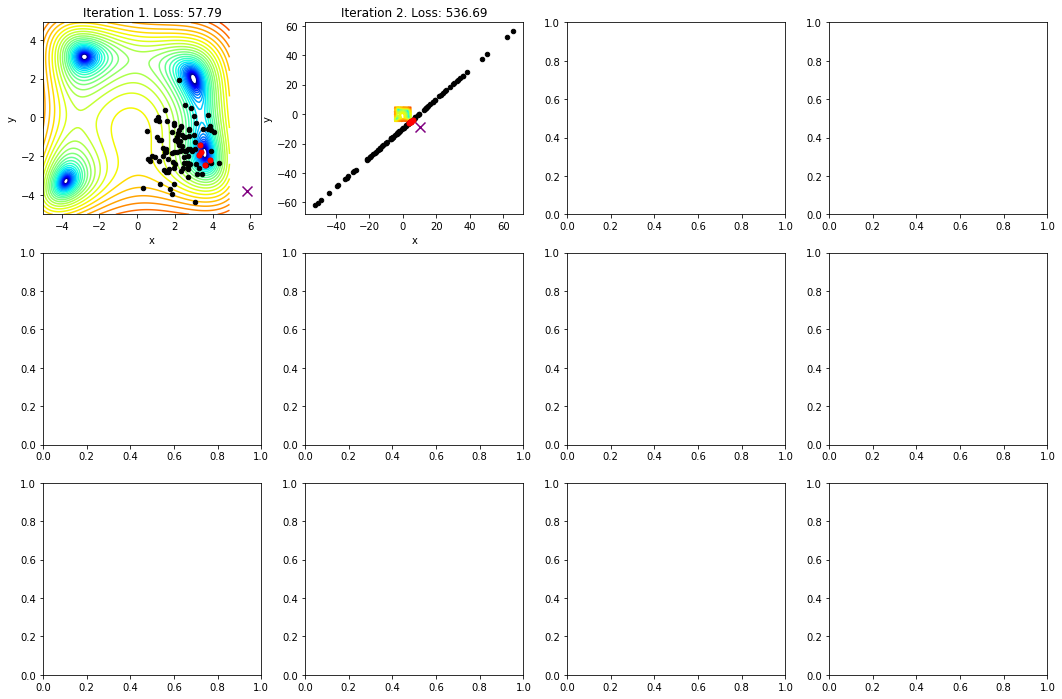

In [127]:
w_dim     = 2
n_iter    = 12
Λ, λ      = 100, 5  # Population size, elite size

controller = CMA_ES(Λ, λ, w_dim)#, d, α_w, α_σ, α_cp, α_c1, α_cλ)
w, reward = controller.train(n_iter, himmelblau_loss)
plt.show()

# Plot reward as a function of generations
plot_reward(n_iter, reward)
plt.show()